In [3]:
%matplotlib inline

!pip install torchsummary

# random seed
random_seed = 1024
import numpy as np # linear algebra
np.random.seed(random_seed)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.utils import resample
import torch
import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary


plt.style.use('seaborn-whitegrid')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/heartbeat'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/mitbih_train.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/ptbdb_normal.csv


Since we have limited number of observations in some of the classes, we merge the train and test CSVs. In this case, we are only interested in the MIT-BIH dataset which are for the multiclass classification. 

In [4]:
# Data Exploration (MIT-BIH)
mitbih_train_loc = "/kaggle/input/heartbeat/mitbih_train.csv"
mitbih_test_loc = "/kaggle/input/heartbeat/mitbih_test.csv"
mitbih_train_df = pd.read_csv(mitbih_train_loc, header=None)
mitbih_test_df = pd.read_csv(mitbih_test_loc, header=None)

dataset = pd.concat([mitbih_train_df, mitbih_test_df], axis=0, sort=True).reset_index(drop=True)

For the MIT-BIH Arrhythmia Dataset, all the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188 as per the [Kaggle dataset remark](https://www.kaggle.com/shayanfazeli/heartbeat).

We have five classes, \['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4\]. Please refer to the corresponding paper entitled [ECG Heartbeat Classification: A Deep Transferable
Representation](https://arxiv.org/pdf/1805.00794.pdf) by Mohammad Kachuee, Shayan Fazeli, and Majid Sarrafzadeh. 
print(mitbih_train_df.iloc[:, -1].unique())
Specifically, classes above refer to the beat annotations enumerated below:
1. N - Normal beat
2. S - Supraventricular premature or ectopic beat (atrial or nodal)
3. V - Premature ventricular contraction
4. F - Fusion of ventricular and normal beat
5. Q - Unclassifiable beat

These classes can be found on the [PhysioBank Annotations](https://archive.physionet.org/physiobank/annotations.shtml) under the Beat Annotations section.

Additionally, each observation in this particular dataset are actual recorded heartbeats of 47 different subjects at a sampling rate of 360Hz annotated by at least two cardiologists under five classes mentioned above in accordance with the Association for the Advancement of Medical Instrumentation (AAMI) standard. The last column indicates how each heartbeat is classified. 

In the following code, we separate labels to their actual observations. Each class are labeled with the ones mentioned above.

In [5]:
labels = dataset.iloc[:, -1].astype('category').map({
    0: 'N - Normal Beat', 
    1: 'S - Supraventricular premature or ectopic beat',
    2: 'V - Premature ventricular contraction', 
    3: 'F - Fusion of ventricular and normal beat', 
    4: 'Q - Unclassified beat'}) 

# since the last column is the category
obs = np.array(dataset.iloc[:, :187]) 

After we separate actual observation and their labels, we will visualize each of the beat classes mentioned above using line graphs.

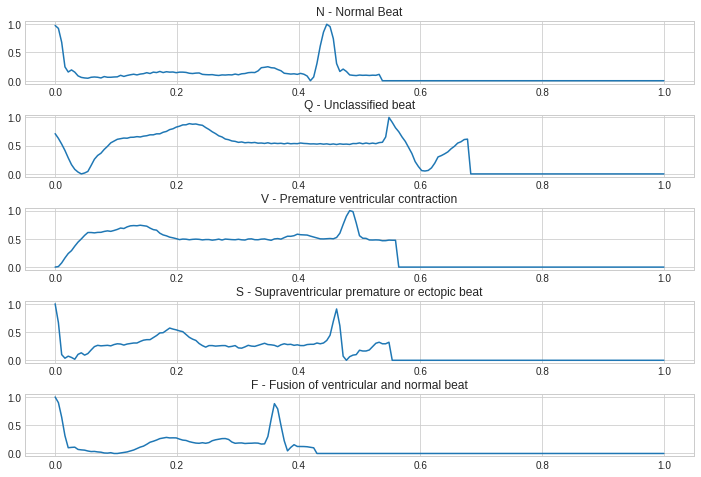

In [6]:
# get the indexes of all labels
n_indexes = labels.index[labels == 'N - Normal Beat']
q_indexes = labels.index[labels == 'Q - Unclassified beat']
v_indexes = labels.index[labels == 'V - Premature ventricular contraction']
s_indexes = labels.index[labels == 'S - Supraventricular premature or ectopic beat']
f_indexes = labels.index[labels == 'F - Fusion of ventricular and normal beat']

# sample one observation per class by indexing the train_labels
n_index = n_indexes[0]
q_index = q_indexes[0]
v_index = v_indexes[0]
s_index = s_indexes[0]
f_index = f_indexes[0]

def generate_subplot(figure, obs, gridspec, row, col, title):
    axis = figure.add_subplot(gridspec[row, col])
    axis.plot(np.linspace(0, 1, 187), obs)
    axis.set_title(title)

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace = .5, wspace=.001)
gs = fig.add_gridspec(5,1)

# for N - Normal Beat
generate_subplot(fig, obs[n_index], gs, 0, 0, 'N - Normal Beat')

# for Q - Unclassified beat
generate_subplot(fig, obs[q_index], gs, 1, 0, 'Q - Unclassified beat')

# for V - Premature ventricular contraction
generate_subplot(fig, obs[v_index], gs, 2, 0, 'V - Premature ventricular contraction')

# for S - Supraventricular premature or ectopic beat
generate_subplot(fig, obs[s_index], gs, 3, 0, 'S - Supraventricular premature or ectopic beat')

# F - Fusion of ventricular and normal beat
generate_subplot(fig, obs[f_index], gs, 4, 0, 'F - Fusion of ventricular and normal beat')

plt.show()

Since the dataset has already been downsampled and preprocessed, we will proceed to visualizing the distribution per classification.

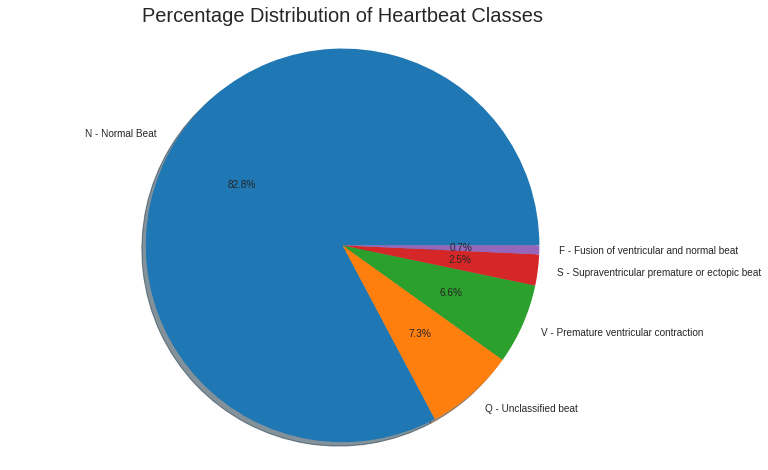

In [7]:
observation_counts = labels.value_counts()
labels_descending = np.array(observation_counts.keys())

fig1, ax1 = plt.subplots()
ax1.pie(observation_counts, labels=labels_descending, autopct='%1.1f%%', startangle=0, shadow=True)
ax1.axis('equal')
fig1.set_size_inches(12,8)
ax1.set_title("Percentage Distribution of Heartbeat Classes", fontsize=20)
plt.show()

In [8]:
print(observation_counts)

N - Normal Beat                                   90589
Q - Unclassified beat                              8039
V - Premature ventricular contraction              7236
S - Supraventricular premature or ectopic beat     2779
F - Fusion of ventricular and normal beat           803
Name: 187, dtype: int64


As you can see, dataset is highly imbalanced. So we need to upsample each classes. This may overfit class F (fusion of ventricular and normal beat b) but its influence to the model will be the same as other classes.

In [9]:
from sklearn.utils import resample

# resample indexes of each class
n_indexes_resampled = resample(n_indexes, replace=True,n_samples=10000,random_state=random_seed)
q_indexes_resampled = resample(q_indexes, replace=True,n_samples=10000,random_state=random_seed)
v_indexes_resampled = resample(v_indexes, replace=True,n_samples=10000,random_state=random_seed)
s_indexes_resampled = resample(s_indexes, replace=True,n_samples=10000,random_state=random_seed)
f_indexes_resampled = resample(f_indexes, replace=True,n_samples=10000,random_state=random_seed)

# initialize the labels_resampled to empty pandas series
labels_resampled = pd.Series([])
obs_resampled = None

# add all indexes_resampled for all classes to iterate
label_indexes_list = [n_indexes_resampled, 
                      q_indexes_resampled, 
                      v_indexes_resampled, 
                      s_indexes_resampled, 
                      f_indexes_resampled]

for label_indexes in label_indexes_list:
    # append labels for all resampled classes
    labels_resampled = labels_resampled.append(labels[label_indexes], ignore_index=True)
    
    # append observations for all resampled classes
    if obs_resampled is None:
        obs_resampled = obs[label_indexes]
    else:
        obs_resampled = np.concatenate((obs_resampled, obs[label_indexes]))

Previously, I resampled all the classes to 10000 observations each. Let us now verify if that is really the case.

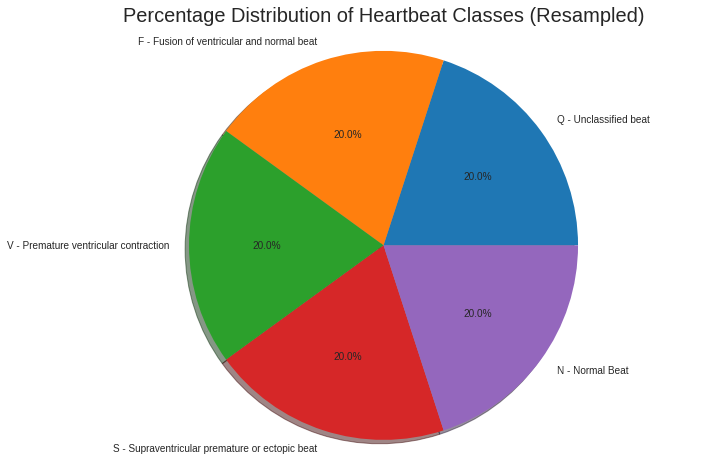

In [10]:
observation_counts = labels_resampled.value_counts()
labels_descending = np.array(observation_counts.keys())

fig1, ax1 = plt.subplots()
ax1.pie(observation_counts, labels=labels_descending, autopct='%1.1f%%', startangle=0, shadow=True)
ax1.axis('equal')
fig1.set_size_inches(12,8)
ax1.set_title("Percentage Distribution of Heartbeat Classes (Resampled)", fontsize=20)
plt.show()

In [11]:
print(observation_counts)

Q - Unclassified beat                             10000
F - Fusion of ventricular and normal beat         10000
V - Premature ventricular contraction             10000
S - Supraventricular premature or ectopic beat    10000
N - Normal Beat                                   10000
dtype: int64


Now we add a little bit of noise to all observations per class with mean 0 and standard deviation of 0.05. This is necessary especially when we are dealing with repeated cases for classes which originally have too few observations before resampling. Then let us see how each of them respond to the noise through line chart comparison.

In [12]:
from scipy.signal import resample

# first version of adding random noise (Gaussian Noise)
mean = 0
std = 0.05
def add_gaussian_noise(signal):
    noise=np.random.normal(mean, std, 187)
    return (signal + noise)

obs_resampled_with_noise_1 = np.array([add_gaussian_noise(obs) for obs in  obs_resampled])

# second version of adding random noise (Amplify and Stretch)
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def add_amplify_and_stretch_noise(x):
    result = np.zeros(shape=187)
    if random.random() < 0.33:
        new_y = stretch(x)
    elif random.random() < 0.66:
        new_y = amplify(x)
    else:
        new_y = stretch(x)
        new_y = amplify(new_y)
    return new_y

obs_resampled_with_noise_2 = np.array([add_amplify_and_stretch_noise(obs) for obs in  obs_resampled])

After executing the above code that creates two versions of data augmentation now we proceed to visualizing side-by-side the comparison between the original and both versions of augmented datasets.

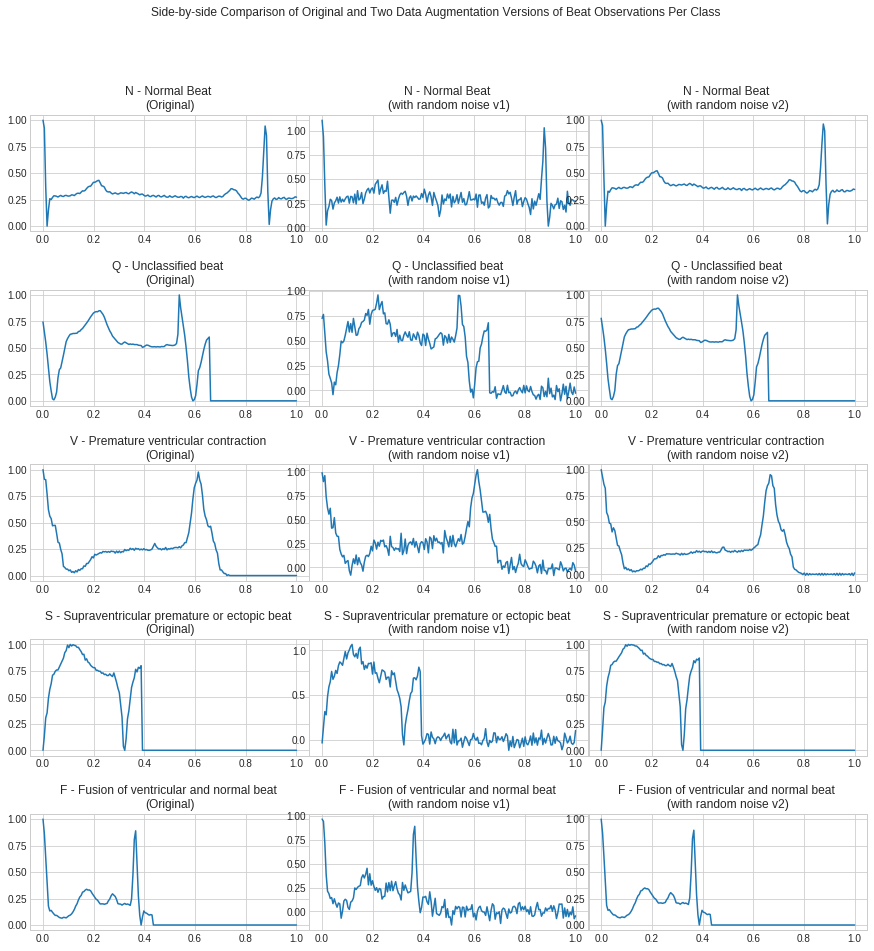

In [13]:
def generate_subplot(figure, obs, gridspec, row, col, title):
    axis = figure.add_subplot(gridspec[row, col])
    axis.plot(np.linspace(0, 1, 187), obs)
    axis.set_title(title)

def generate_plots_for_a_specific_data_augmentation(obs_resampled, obs_resampled_with_noise_1, obs_resampled_with_noise_2):
    # sample one observation per class by indexing the train_labels
    n_index = 0
    q_index = 10000
    v_index = 20000
    s_index = 30000
    f_index = 40000
    
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    gs = fig.add_gridspec(5, 3)

    # for N - Normal Beat
    generate_subplot(fig, obs_resampled[n_index], gs, 0, 0, 'N - Normal Beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[n_index], gs, 0, 1, 'N - Normal Beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[n_index], gs, 0, 2, 'N - Normal Beat \n(with random noise v2)')

    # for Q - Unclassified beat
    generate_subplot(fig, obs_resampled[q_index], gs, 1, 0, 'Q - Unclassified beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[q_index], gs, 1, 1, 'Q - Unclassified beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[q_index], gs, 1, 2, 'Q - Unclassified beat \n(with random noise v2)')

    # for V - Premature ventricular contraction
    generate_subplot(fig, obs_resampled[v_index], gs, 2, 0, 'V - Premature ventricular contraction \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[v_index], gs, 2, 1, 'V - Premature ventricular contraction \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[v_index], gs, 2, 2, 'V - Premature ventricular contraction \n(with random noise v2)')

    # for S - Supraventricular premature or ectopic beat
    generate_subplot(fig, obs_resampled[s_index], gs, 3, 0, 'S - Supraventricular premature or ectopic beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[s_index], gs, 3, 1, 'S - Supraventricular premature or ectopic beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[s_index], gs, 3, 2, 'S - Supraventricular premature or ectopic beat \n(with random noise v2)')

    # F - Fusion of ventricular and normal beat
    generate_subplot(fig, obs_resampled[f_index], gs, 4, 0, 'F - Fusion of ventricular and normal beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[f_index], gs, 4, 1, 'F - Fusion of ventricular and normal beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[f_index], gs, 4, 2, 'F - Fusion of ventricular and normal beat \n(with random noise v2)')

    plt.suptitle('Side-by-side Comparison of Original and Two Data Augmentation Versions of Beat Observations Per Class')
    plt.show()
    
generate_plots_for_a_specific_data_augmentation(obs_resampled, obs_resampled_with_noise_1, obs_resampled_with_noise_2)

Noow that we generated a significant amount of observations for the project let us now split the dataset to train, test and validation. The following divides the dataset 80/20 where the former is for training and the latter is for the test and validation equally splitted.

In [14]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use for testing and validation
test_valid_size = 0.2
# percentage of test/valid set to use for testing and validation from the test_valid_idx (to be called test_size)
test_size = 0.5


# obtain training indices that will be used for validation
num_train = len(obs_resampled)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_valid_size * num_train))
train_idx, test_valid_idx = indices[split:], indices[:split]

# split test_valid_idx to test_idx and valid_idx
num_test_valid = len(test_valid_idx)
test_valid_split = int(num_test_valid * test_size)
test_idx, valid_idx = test_valid_idx[:test_valid_split], test_valid_idx[test_valid_split:]

As you can see, a slight random noise is added to each of the observations selected per class. This will ensure that the neural network will generalize in training. Now we proceed to model building.

The inspiration for this project is from the paper ECG Heartbeat Classification: A Deep Transferable Representation by Mohammad Kachuee, Shayan Fazeli, Majid Sarrafzadeh. Shayan Fazeli compiled the dataset that is used in this project. 

The proposed network that worked in this project is displayed in the following section:

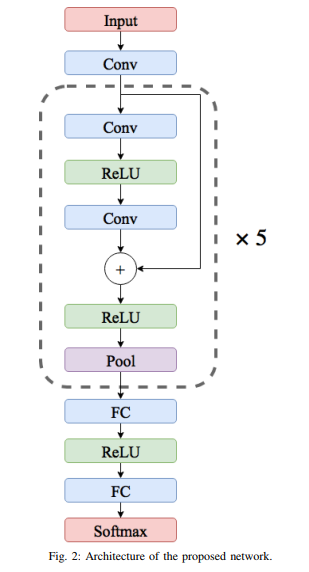

In [15]:
from IPython.display import Image 
Image("../input/images/network.png")

Now let us proceed to model preparation and building

In [16]:
# Batch Size of 32
batch_size = 32

def convert_to_loader(X, y, batch_size):
    data = []
    for i in range(len(X)):
        data.append([X[i], y[i]])
    
    # drop last since it causes problems on the validation dataset
    loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    
    return loader
    
# convert labels_resampled to its integer encoding of the following listing:
#     0: 'N - Normal Beat'
#     1: 'S - Supraventricular premature or ectopic beat'
#     2: 'V - Premature ventricular contraction'
#     3: 'F - Fusion of ventricular and normal beat' 
#     4: 'Q - Unclassified beat
labels_resampled_factorized = pd.factorize(labels_resampled.astype('category'))[0]


# now we create separate data loaders for both datasets with different data augmentation. Models will be trained for each

# for data augmentation v1 (Add Gaussian Noise)
train_loader_1 = convert_to_loader(obs_resampled_with_noise_1[train_idx], 
                                 labels_resampled_factorized[train_idx],
                                 batch_size)
valid_loader_1 = convert_to_loader(obs_resampled_with_noise_1[valid_idx], 
                                 labels_resampled_factorized[valid_idx],
                                 batch_size)
test_loader_1 = convert_to_loader(obs_resampled_with_noise_1[test_idx], 
                                 labels_resampled_factorized[test_idx],
                                 batch_size)

# for data augmentation v2 (Amplify and Stretch)
train_loader_2 = convert_to_loader(obs_resampled_with_noise_2[train_idx], 
                                 labels_resampled_factorized[train_idx],
                                 batch_size)
valid_loader_2 = convert_to_loader(obs_resampled_with_noise_2[valid_idx], 
                                 labels_resampled_factorized[valid_idx],
                                 batch_size)
test_loader_2 = convert_to_loader(obs_resampled_with_noise_2[test_idx], 
                                 labels_resampled_factorized[test_idx],
                                 batch_size)

Now that we already prepared the data suitable for training (i.e. build the train, validation and test loaders, let us now proceed with creating the model architecture. You can see from the above code that the loaders are done with PyTorch helper functions. That is the framework that we will use all throughout the training process.

In [17]:
# define the 1st architecture
class Net1(nn.Module):
    def __init__(self, input_features, output_dim):
        super(Net1, self).__init__()
        # 1-dimensional convolutional layer
        self.conv0 = nn.Conv1d(input_features, 32, output_dim, stride=1, padding=0)
        self.conv1 = nn.Conv1d(32, 32, output_dim, stride=1, padding=2)
        self.conv2 = nn.Conv1d(32, 128, output_dim, stride=1, padding=2)
        
        # max pooling layer
        self.pool1 = nn.MaxPool1d(5, 2)
        
        # fully-connected layer
        self.fc1 = nn.Linear(256, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        
        inp = x.view(32, -1, 187)
        C = self.conv0(inp)
        
        # first conv layer
        C11 = self.conv0(inp)
        A11 = F.relu(C11)
        C12 = self.conv1(A11)
        S11 = torch.add(C12, C)
        A12 = F.relu(S11)
        M11 = self.pool1(A12)
        
        # second conv layer
        C21 = self.conv1(M11)
        A21 = F.relu(C21)
        C22 = self.conv1(A21)
        S21 = torch.add(C22, M11)
        A22 = F.relu(S21)
        M21 = self.pool1(A22)
        
        # third conv layer
        C31 = self.conv1(M21)
        A31 = F.relu(C31)
        C32 = self.conv1(A31)
        S31 = torch.add(C32, M21)
        A32 = F.relu(S31)
        M31 = self.pool1(A32)
        
        # fourth conv layer
        C41 = self.conv1(M31)
        A41 = F.relu(C41)
        C42 = self.conv1(A41)
        S41 = torch.add(C42, M31)
        A42 = F.relu(S41)
        M41 = self.pool1(A42)
        
        # flatten the output of the last layer
        F1 = M41.view(32, -1)
        
        D1 = self.fc1(F1)
        A6 = F.relu(D1)
        D2 = self.fc2(A6)
        D3 = self.fc3(A6)
        
#         return D3
        return self.softmax(D3)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Net1(input_features=2, output_dim=5).to(device)

# check keras-like model summary using torchsummary

summary(model1, (32, 187))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 183]             352
            Conv1d-2              [-1, 32, 183]             352
            Conv1d-3              [-1, 32, 183]           5,152
         MaxPool1d-4               [-1, 32, 90]               0
            Conv1d-5               [-1, 32, 90]           5,152
            Conv1d-6               [-1, 32, 90]           5,152
         MaxPool1d-7               [-1, 32, 43]               0
            Conv1d-8               [-1, 32, 43]           5,152
            Conv1d-9               [-1, 32, 43]           5,152
        MaxPool1d-10               [-1, 32, 20]               0
           Conv1d-11               [-1, 32, 20]           5,152
           Conv1d-12               [-1, 32, 20]           5,152
        MaxPool1d-13                [-1, 32, 8]               0
           Linear-14                   

In [19]:
# define the 1st architecture (from the paper)
class Net2(nn.Module):
    def __init__(self, input_features, output_dim):
        super(Net2, self).__init__()
        # 1-dimensional convolutional layer
        self.conv0 = nn.Conv1d(input_features, 128, output_dim, stride=1, padding=0)
        self.conv1 = nn.Conv1d(128, 128, output_dim, stride=1, padding=2)
        
        # max pooling layer
        self.pool1 = nn.MaxPool1d(5, 2)
        
        # fully-connected layer
        self.fc1 = nn.Linear(256, 32)
        self.fc2 = nn.Linear(32, output_dim)
        
        # softmax output
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        
        inp = x.view(32, -1, 187)
        C = self.conv0(inp)
        
        # first conv layer
        C11 = self.conv0(inp)
        A11 = F.relu(C11)
        C12 = self.conv1(A11)
        S11 = torch.add(C12, C)
        M11 = self.pool1(S11)
        
        # second conv layer
        C21 = self.conv1(M11)
        A21 = F.relu(C21)
        C22 = self.conv1(A21)
        S21 = torch.add(C22, M11)
        M21 = self.pool1(S21)
        
        # third conv layer
        C31 = self.conv1(M21)
        A31 = F.relu(C31)
        C32 = self.conv1(A31)
        S31 = torch.add(C32, M21)
        M31 = self.pool1(S31)
        
        # fourth conv layer
        C41 = self.conv1(M31)
        A41 = F.relu(C41)
        C42 = self.conv1(A41)
        S41 = torch.add(C42, M31)
        M41 = self.pool1(S41)
        
        # last layer
        C51 = self.conv1(M41)
        A51 = F.relu(C51)
        C52 = self.conv1(A51)
        S51 = torch.add(C52, M41)
        M51 = self.pool1(S51)
        
        # flatten the output of the last layer
        F1 = M51.view(32, -1)
        
        D1 = self.fc1(F1)
        A6 = F.relu(D1)
        D2 = self.fc2(A6)
        
        return self.softmax(D2)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Net2(input_features=2, output_dim=5).to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model2, (32, 187))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 183]           1,408
            Conv1d-2             [-1, 128, 183]           1,408
            Conv1d-3             [-1, 128, 183]          82,048
         MaxPool1d-4              [-1, 128, 90]               0
            Conv1d-5              [-1, 128, 90]          82,048
            Conv1d-6              [-1, 128, 90]          82,048
         MaxPool1d-7              [-1, 128, 43]               0
            Conv1d-8              [-1, 128, 43]          82,048
            Conv1d-9              [-1, 128, 43]          82,048
        MaxPool1d-10              [-1, 128, 20]               0
           Conv1d-11              [-1, 128, 20]          82,048
           Conv1d-12              [-1, 128, 20]          82,048
        MaxPool1d-13               [-1, 128, 8]               0
           Conv1d-14               [-1,

Now that all of the models are created, let us now train each of them using two versions of train and validation loaders.

Below is the function that generalizes the training job for a combination of custom model to be trained as well as the dataset to train

In [21]:
def train_by_model_and_custom_loader(model, train_loader, valid_loader, criterion, optimizer, best_model_name, n_epochs, train_on_gpu):
    model = model.float()
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        model.cuda()
    valid_loss_min = np.Inf # track change in validation loss
    valid_losses = []

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        
        valid_losses.append(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), best_model_name)
            valid_loss_min = valid_loss
            
    return valid_losses

In [22]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# number of epochs
num_epochs = 50

CUDA is available!  Training on GPU ...


In [23]:
def train_by_model_and_custom_loader(model, train_loader, valid_loader, criterion, optimizer, best_model_name, n_epochs, train_on_gpu):
    model = model.float()
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        model.cuda()
    valid_loss_min = np.Inf # track change in validation loss
    valid_losses = []

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        
        valid_losses.append(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), best_model_name)
            valid_loss_min = valid_loss
            
    return valid_losses

In [24]:
# create a complete CNN
model_1 = Net1(input_features=1, output_dim=5)
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
model_1_validation_losses = train_by_model_and_custom_loader(model_1, train_loader_1, valid_loader_1, criterion, optimizer, 'model_ecg_heartbeat_categorization_1.pt', num_epochs, train_on_gpu)

Epoch: 1 	Training Loss: 0.613900 	Validation Loss: 0.410949
Validation loss decreased (inf --> 0.410949).  Saving model ...
Epoch: 2 	Training Loss: 0.358691 	Validation Loss: 0.319676
Validation loss decreased (0.410949 --> 0.319676).  Saving model ...
Epoch: 3 	Training Loss: 0.291023 	Validation Loss: 0.284921
Validation loss decreased (0.319676 --> 0.284921).  Saving model ...
Epoch: 4 	Training Loss: 0.255603 	Validation Loss: 0.243239
Validation loss decreased (0.284921 --> 0.243239).  Saving model ...
Epoch: 5 	Training Loss: 0.231176 	Validation Loss: 0.211452
Validation loss decreased (0.243239 --> 0.211452).  Saving model ...
Epoch: 6 	Training Loss: 0.210017 	Validation Loss: 0.244705
Epoch: 7 	Training Loss: 0.195362 	Validation Loss: 0.195043
Validation loss decreased (0.211452 --> 0.195043).  Saving model ...
Epoch: 8 	Training Loss: 0.182626 	Validation Loss: 0.190174
Validation loss decreased (0.195043 --> 0.190174).  Saving model ...
Epoch: 9 	Training Loss: 0.167457 

In [25]:
# create a complete CNN
model_2 = Net1(input_features=1, output_dim=5)
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
model_2_validation_losses = train_by_model_and_custom_loader(model_2, train_loader_2, valid_loader_2, criterion, optimizer, 'model_ecg_heartbeat_categorization_2.pt', num_epochs, train_on_gpu)

Epoch: 1 	Training Loss: 0.674710 	Validation Loss: 0.444090
Validation loss decreased (inf --> 0.444090).  Saving model ...
Epoch: 2 	Training Loss: 0.403482 	Validation Loss: 0.370110
Validation loss decreased (0.444090 --> 0.370110).  Saving model ...
Epoch: 3 	Training Loss: 0.331413 	Validation Loss: 0.322926
Validation loss decreased (0.370110 --> 0.322926).  Saving model ...
Epoch: 4 	Training Loss: 0.287442 	Validation Loss: 0.290706
Validation loss decreased (0.322926 --> 0.290706).  Saving model ...
Epoch: 5 	Training Loss: 0.256813 	Validation Loss: 0.289271
Validation loss decreased (0.290706 --> 0.289271).  Saving model ...
Epoch: 6 	Training Loss: 0.231835 	Validation Loss: 0.241520
Validation loss decreased (0.289271 --> 0.241520).  Saving model ...
Epoch: 7 	Training Loss: 0.213258 	Validation Loss: 0.230122
Validation loss decreased (0.241520 --> 0.230122).  Saving model ...
Epoch: 8 	Training Loss: 0.200999 	Validation Loss: 0.215483
Validation loss decreased (0.23012

In [26]:
# create a complete CNN
model_3 = Net2(input_features=1, output_dim=5)
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model_3.parameters(), lr=0.001)
model_3_validation_losses = train_by_model_and_custom_loader(model_3, train_loader_1, valid_loader_1, criterion, optimizer, 'model_ecg_heartbeat_categorization_3.pt', num_epochs, train_on_gpu)

Epoch: 1 	Training Loss: 0.507788 	Validation Loss: 0.287575
Validation loss decreased (inf --> 0.287575).  Saving model ...
Epoch: 2 	Training Loss: 0.262441 	Validation Loss: 0.213415
Validation loss decreased (0.287575 --> 0.213415).  Saving model ...
Epoch: 3 	Training Loss: 0.207650 	Validation Loss: 0.195532
Validation loss decreased (0.213415 --> 0.195532).  Saving model ...
Epoch: 4 	Training Loss: 0.178368 	Validation Loss: 0.180099
Validation loss decreased (0.195532 --> 0.180099).  Saving model ...
Epoch: 5 	Training Loss: 0.155379 	Validation Loss: 0.194982
Epoch: 6 	Training Loss: 0.147441 	Validation Loss: 0.151473
Validation loss decreased (0.180099 --> 0.151473).  Saving model ...
Epoch: 7 	Training Loss: 0.133195 	Validation Loss: 0.157563
Epoch: 8 	Training Loss: 0.129026 	Validation Loss: 0.175059
Epoch: 9 	Training Loss: 0.123975 	Validation Loss: 0.118617
Validation loss decreased (0.151473 --> 0.118617).  Saving model ...
Epoch: 10 	Training Loss: 0.111526 	Valida

In [27]:
# create a complete CNN
model_4 = Net2(input_features=1, output_dim=5)
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model_4.parameters(), lr=0.001)
model_4_validation_losses = train_by_model_and_custom_loader(model_4, train_loader_2, valid_loader_2, criterion, optimizer, 'model_ecg_heartbeat_categorization_4.pt', num_epochs, train_on_gpu)

Epoch: 1 	Training Loss: 0.558462 	Validation Loss: 0.389737
Validation loss decreased (inf --> 0.389737).  Saving model ...
Epoch: 2 	Training Loss: 0.288895 	Validation Loss: 0.235172
Validation loss decreased (0.389737 --> 0.235172).  Saving model ...
Epoch: 3 	Training Loss: 0.214923 	Validation Loss: 0.200439
Validation loss decreased (0.235172 --> 0.200439).  Saving model ...
Epoch: 4 	Training Loss: 0.178277 	Validation Loss: 0.199458
Validation loss decreased (0.200439 --> 0.199458).  Saving model ...
Epoch: 5 	Training Loss: 0.152634 	Validation Loss: 0.142622
Validation loss decreased (0.199458 --> 0.142622).  Saving model ...
Epoch: 6 	Training Loss: 0.137218 	Validation Loss: 0.132969
Validation loss decreased (0.142622 --> 0.132969).  Saving model ...
Epoch: 7 	Training Loss: 0.124730 	Validation Loss: 0.130790
Validation loss decreased (0.132969 --> 0.130790).  Saving model ...
Epoch: 8 	Training Loss: 0.115586 	Validation Loss: 0.110656
Validation loss decreased (0.13079

Now we load the model with lowest validation score.

In [28]:
def evaluate_model(model, test_loader, criterion, best_model_name):
    model.load_state_dict(torch.load(best_model_name))
    
    # Specify the heartbeat classes from above
    classes = {
        0: 'N - Normal Beat', 
        1: 'S - Supraventricular premature or ectopic beat',
        2: 'V - Premature ventricular contraction', 
        3: 'F - Fusion of ventricular and normal beat', 
        4: 'Q - Unclassified beat'}

    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(5))
    class_total = list(0. for i in range(5))

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the batch loss
        loss = criterion(output, target.long())
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i].int()
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(5):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [29]:
evaluate_model(model_1, test_loader_1, criterion, 'model_ecg_heartbeat_categorization_1.pt')

Test Loss: 0.128242

Test Accuracy of N - Normal Beat: 90% (893/986)
Test Accuracy of S - Supraventricular premature or ectopic beat: 99% (999/1003)
Test Accuracy of V - Premature ventricular contraction: 95% (948/994)
Test Accuracy of F - Fusion of ventricular and normal beat: 93% (940/1001)
Test Accuracy of Q - Unclassified beat: 98% (996/1008)

Test Accuracy (Overall): 95% (4776/4992)


In [30]:
evaluate_model(model_2, test_loader_2, criterion, 'model_ecg_heartbeat_categorization_2.pt')

Test Loss: 0.123020

Test Accuracy of N - Normal Beat: 93% (921/985)
Test Accuracy of S - Supraventricular premature or ectopic beat: 99% (993/1002)
Test Accuracy of V - Premature ventricular contraction: 95% (943/989)
Test Accuracy of F - Fusion of ventricular and normal beat: 95% (960/1007)
Test Accuracy of Q - Unclassified beat: 97% (985/1009)

Test Accuracy (Overall): 96% (4802/4992)


In [31]:
evaluate_model(model_3, test_loader_1, criterion, 'model_ecg_heartbeat_categorization_3.pt')

Test Loss: 0.128251

Test Accuracy of N - Normal Beat: 93% (921/986)
Test Accuracy of S - Supraventricular premature or ectopic beat: 97% (973/1002)
Test Accuracy of V - Premature ventricular contraction: 95% (946/990)
Test Accuracy of F - Fusion of ventricular and normal beat: 94% (949/1006)
Test Accuracy of Q - Unclassified beat: 98% (993/1008)

Test Accuracy (Overall): 95% (4782/4992)


In [32]:
evaluate_model(model_4, test_loader_2, criterion, 'model_ecg_heartbeat_categorization_4.pt')

Test Loss: 0.108691

Test Accuracy of N - Normal Beat: 93% (917/986)
Test Accuracy of S - Supraventricular premature or ectopic beat: 99% (991/1001)
Test Accuracy of V - Premature ventricular contraction: 96% (955/992)
Test Accuracy of F - Fusion of ventricular and normal beat: 96% (972/1006)
Test Accuracy of Q - Unclassified beat: 98% (992/1007)

Test Accuracy (Overall): 96% (4827/4992)


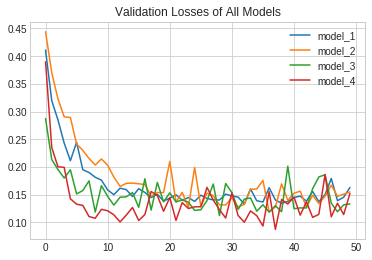

In [33]:
validation_losses = {
    "model_1": model_1_validation_losses,
    "model_2": model_2_validation_losses,
    "model_3": model_3_validation_losses,
    "model_4": model_4_validation_losses
}
# plt.plot(model_1_validation_losses)

plt.plot('model_1', data=validation_losses)
plt.plot('model_2', data=validation_losses)
plt.plot('model_3', data=validation_losses)
plt.plot('model_4', data=validation_losses)
plt.title("Validation Losses of All Models")
plt.legend(validation_losses.keys())